# 0.0 IMPORTS

In [1]:
import inflection
import math
import datetime
import pandas  as pd
import numpy   as np
import seaborn as sns
import boruta  as BorutaPy
import xgboost as xgb
import pickle
import random
import warnings
warnings.filterwarnings('ignore')
import matplotlib.gridspec as gridspec



from IPython.core.display  import HTML
from IPython.display       import Image
from scipy                 import stats as ss
from matplotlib            import pyplot as plt

from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


## 0.1. Helder Functions

In [2]:
def cramer_v (x,y):
    cm = pd.crosstab(x,y).to_numpy()    
    n = cm.sum()
    r , k = cm.shape    
    chi2 = ss.chi2_contingency(cm)[0]
    chi2corr = max(0,chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)    
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1,rcorr-1)))

def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] =[25,12]
    plt.rcParams['font.size'] =24
    
    display( HTML( '<style>.container { width:100% !important; }</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()           
    

def mean_absolute_percentage_error(y , yhat):
    return np.mean(np.abs( ( y - yhat ) / y ))

def ml_error(model_name, y, yhat):
    mae = mean_absolute_error( y , yhat)
    mape = mean_absolute_percentage_error(y, yhat)
    rmse = np.sqrt(mean_squared_error( y, yhat))
    
    return pd.DataFrame({'Model Name': model_name,
                        'MAE': mae,
                        'MAPE': mape,
                        'RMSE': rmse }, index=[0])

def cross_validation(x_training,kfold, model_name, model, verbose=True):
    mae_list= []
    mape_list = []
    rmse_list =[]   
   
    for k in reversed(range(1,kfold + 1)):
        if verbose:
            print('\nKfold Number:{}'.format(k))
        #start and end date for validation 
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[ (x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date) ]

        #training and validation dataset
        #training
        xtraining = training.drop(['date','sales'], axis = 1)
        ytraining = training['sales']

        xvalidation = validation.drop(['date', 'sales'] , axis = 1)
        yvalidation = validation['sales']


        #model
        m = model.fit(xtraining, ytraining)

        #predction
        yhat = m.predict(xvalidation)

        #performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        #Performace KFOLD
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])  
        


    return pd.DataFrame( {'Model Name' : model_name,
                          'MAE CV' : np.round(np.mean(mae_list),2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                          'MAPE CV' : np.round(np.mean(mape_list),2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                          'RMSE CV' : np.round(np.mean(rmse_list),2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)},index=[0])


In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

In [4]:
df_sales_raw = pd.read_csv('Data/train.csv',low_memory = False)
df_store_raw = pd.read_csv('Data/store.csv',low_memory = False)

#merge
df_raw = pd.merge(df_sales_raw,df_store_raw, how='left',on='Store')

# PASSO 01- 1.0. DESCRIÇÃO DOS DADOS


## 1.1.Rename Columns

In [5]:
df1 = df_raw.copy() 

In [6]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [7]:
## Mudando o estilo da colunas para snakecase
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo','StateHoliday', 'SchoolHoliday', 'StoreType', 
            'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'Promo2', 
            'Promo2SinceWeek','Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)

cols_new = list (map(snakecase,cols_old))

#rename
df1.columns = cols_new


## 1.2. Data Dimensions

In [8]:
print("Number Rows    : {}".format(df1.shape[0]))
print("Number Columns : {}".format(df1.shape[1]))

Number Rows    : 1017209
Number Columns : 18


## 1.3 Data Types

In [9]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [10]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA

In [11]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

In [12]:
#competition_distance        
max_valeu = df1['competition_distance'].max()
max_valeu = max_valeu * 2
df1['competition_distance'] = df1['competition_distance'].apply(lambda x : max_valeu if math.isnan(x) else x)

#competition_open_since_month    
df1['competition_open_since_month'] =df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

#competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'],axis=1)

#promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'],axis =1)

#promo2_since_year 
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)


#promo_interval
month_map = {1:'Jan',2:'Fev',3:'Mar',4:'Apr',5:'May',6:'Jun',7:'Jul',8:'Aug',9:'Sep',10:'Oct',11:'Nov',12:'Dec'}

df1['promo_interval'].fillna(0, inplace = True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] =df1[['promo_interval','month_map']].apply(lambda x :0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis =1)




## 1.6. Change Type

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [16]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year']  = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week']            = df1['promo2_since_week'].astype(int)
df1['promo2_since_year']            = df1['promo2_since_year'].astype(int)

## 1.7. Description Statical

In [17]:
num_attributes = df1.select_dtypes(include =['int64','int32','float64'])
cat_attributes = df1.select_dtypes(exclude =['int64','float64','int32','datetime64[ns]'])

## 1.7.1 Numerical Attributes

In [18]:
# Central Tendency - mean,median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispercion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

#Concate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns =['attributes','min','max','range','mean','median','std','skew','kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,151720.0,151700.0,5810.044888,2330.0,10715.007635,7.593832,90.447876
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


<AxesSubplot:xlabel='competition_distance', ylabel='Density'>

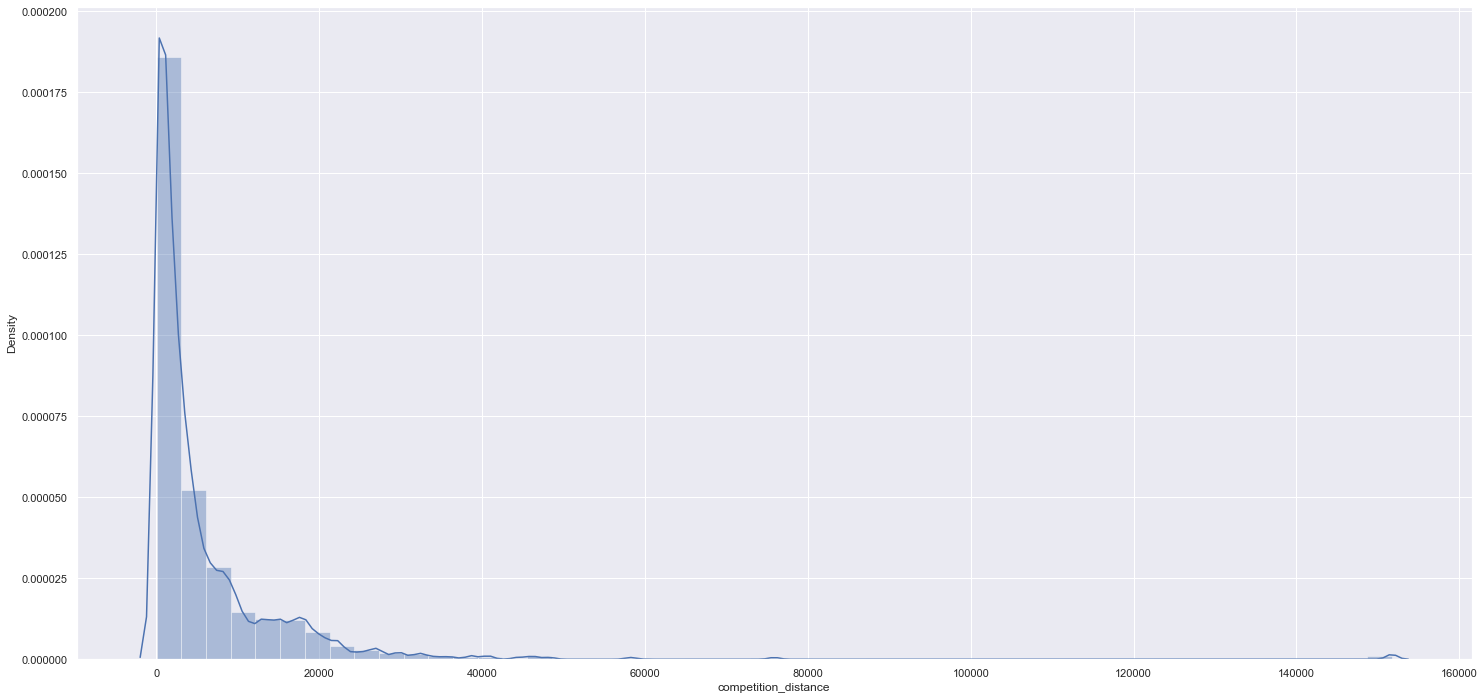

In [19]:
sns.distplot(df1['competition_distance'])

## 1.7.2 Categorial Attributes

In [20]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

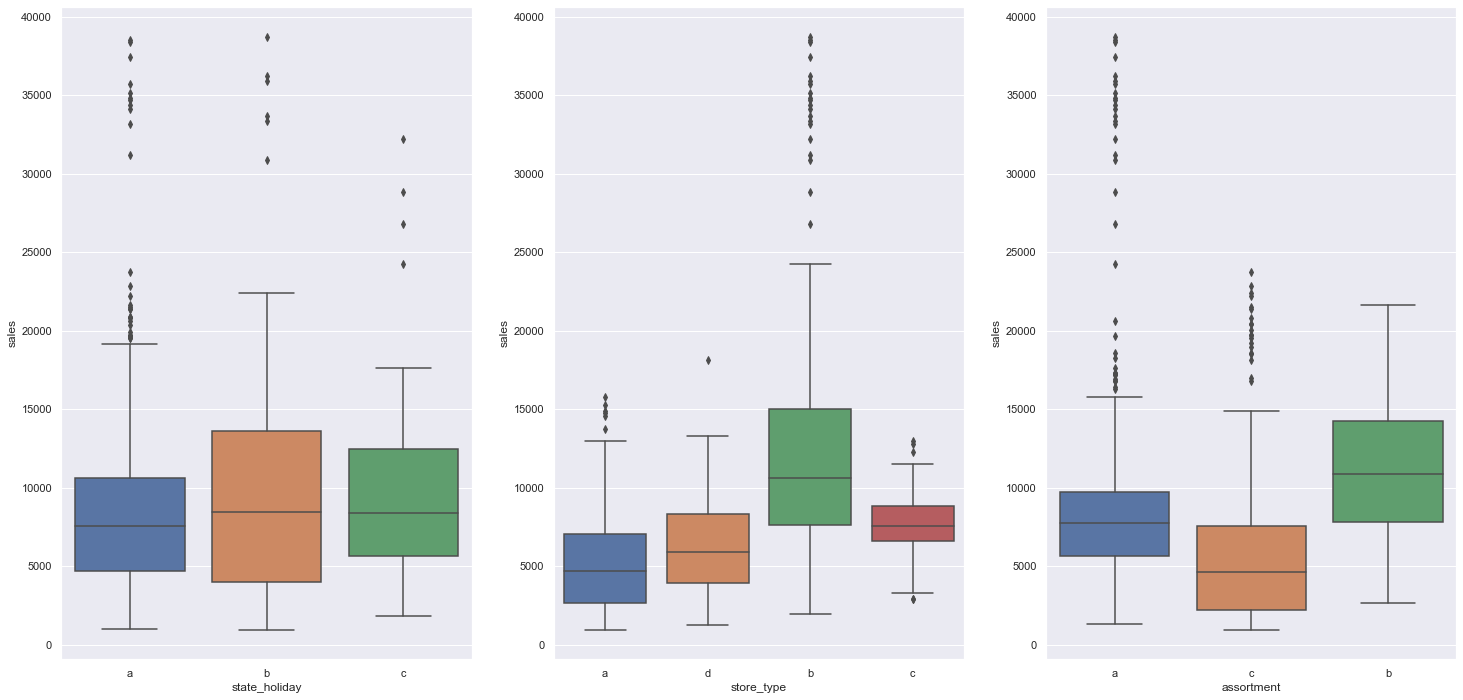

In [21]:
aux1 = df1[(df1['state_holiday'] !='0') & (df1['sales'] > 0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# PASSO 02 - 2.0. FEATURE ENGINERING

In [22]:
df2 = df1.copy()

## 2.1. Mapa Mental das Hipoteses

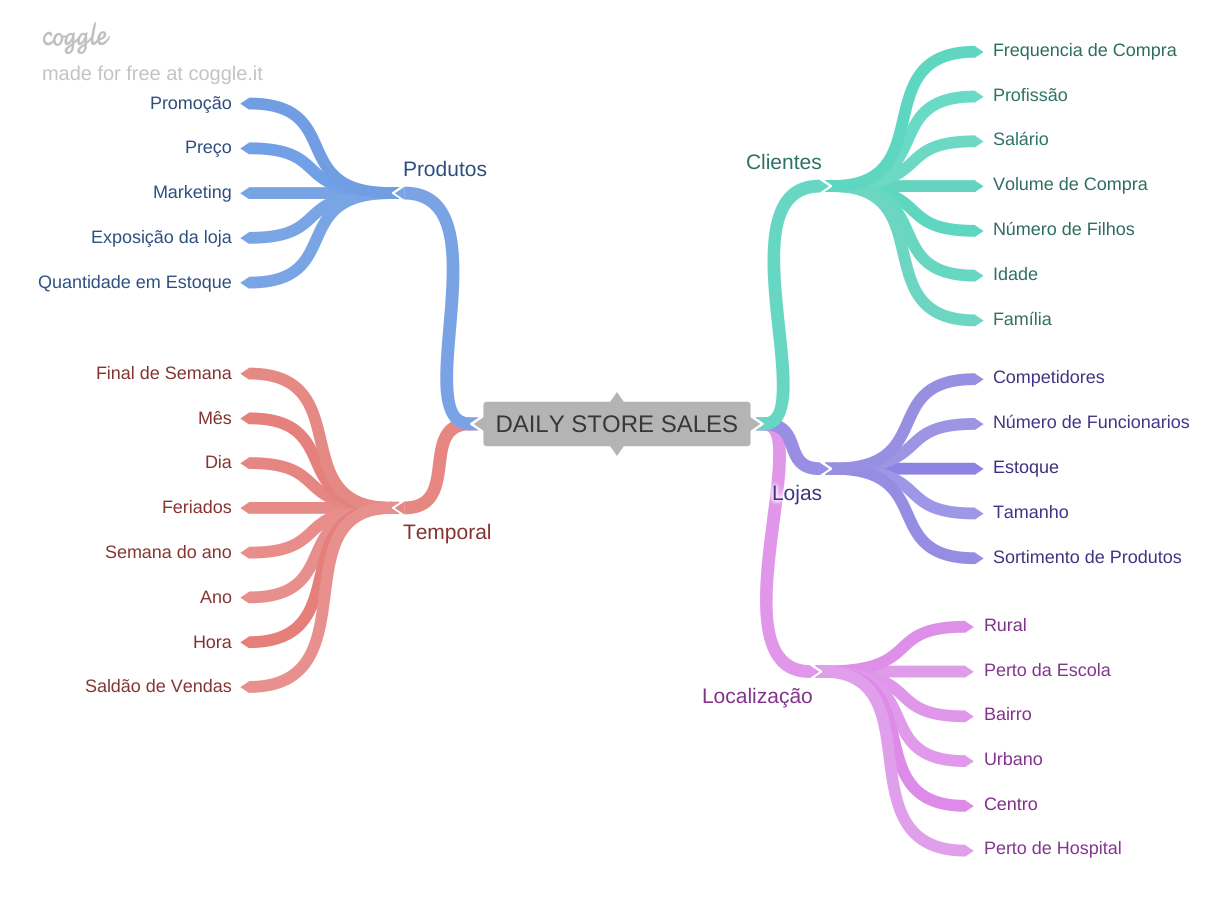

In [23]:
Image( 'img/MindMapHypothesis.png')

## 2.2. Criação das Hipoteses

### 2.1.1 Hipoteses da Loja

**1.** Lojas com maior número de funcionarios deveriam vender mais.

**2.** Lojas com maior capacidade de estoque deveriam vender mais.

**3.** Lojas com maior porte deveriam vender mais.

**4.** Lojas com maior sortimento deveriam vender mais.

**5.** Lojas com competidores mais próximos deveriam vender menos.

**6.** Lojas com competidores á mais tempo deveriam vender mais.

### 2.1.2 Hipoteses do Produto

**1.** Lojas que investem mais em marketing deveriam vender mais.

**2.** Lojas com maior exposição dos produtos deveriam vender mais.

**3.** Lojas com produtos com preço menor deveriam vender mais.

**4.** Lojas com promoções mais agressivas (descontos maiores), devem vender mais.

**5.** Lojas com promoções ativas por mais tempo, deveriam vender mais.

**6.** Lojas com mais dias de promoção deveriam vender mais.

**7.** Lojas com mais promoções consecutivas deveriam vender mais.

### 2.1.3 Hipoteses do Tempo

**1.** Lojas aberta durante o feriado de Natal deveriam vender mais.

**2.** Lojas deveriam vender mais ao longo dos anos.

**3.** Lojas deveriam vender mais no segundo semestre do ano.

**4.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**5.** Lojas deveriam vender menos aos finais de semana.

**6.** Lojas deveriam vender menos durante os feriados escolares.

## 2.3. Feature Engineerging

In [24]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competiton_since'] = df2.apply(lambda x : datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis =1)
df2['competition_time_month'] =((df2['date']  - df2['competiton_since']) / 30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' + df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2['promo_since'].apply(lambda x :datetime.datetime.strptime(x + '-1', '%Y-%W-%w' ) - datetime.timedelta(days = 7))
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'cristmas' if x == 'c' else 'regular_day')



In [25]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


## 2.4. Lista Final das Hipoteses

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais proximos deveriam vender menos.

**3.** lojas com competidores a mais tempo deveriam vender mais.

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais.

**5.** Lojas com mais dias de promoção deveriam vender mais.

**6.** Lojas com mais promoções consecutivas deveriam vender mais.

**7.** Lojas abertas durante o feriado de Natal deveriam vender mais.

**8.** Lojas deveriam vender mais ao longo do ano

**9.** Lojas deveriam vender mais no segundo semestre do ano

**10.** Lojas deveriam vender mais depois do dia 10 de cada mês.

**11.** Lojas deveriam vender menos ao finais de semana.

**12.** Lojas deveriam vender menos durantes os feriados escolares.

# PASSO 03 - 3.0. FILTRAGEM DE VARIAVEIS

In [26]:
df3 = df2.copy()

## 3.1. Filtragem das linhas

In [27]:
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2. Filtragem das Colunas

In [28]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [29]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competiton_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# PASSO 04 - 4.0. ANALISE EXPLORATORIA DOS DADOS

In [30]:
df4 = df3.copy()

## 4.1 Analise Univariada

### 4.1.1 Response Variable

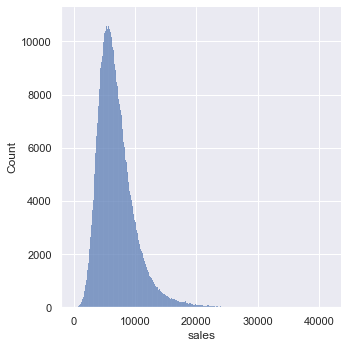

In [31]:
sns.displot(df4['sales'])

### 4.1.2 Numerical Variable

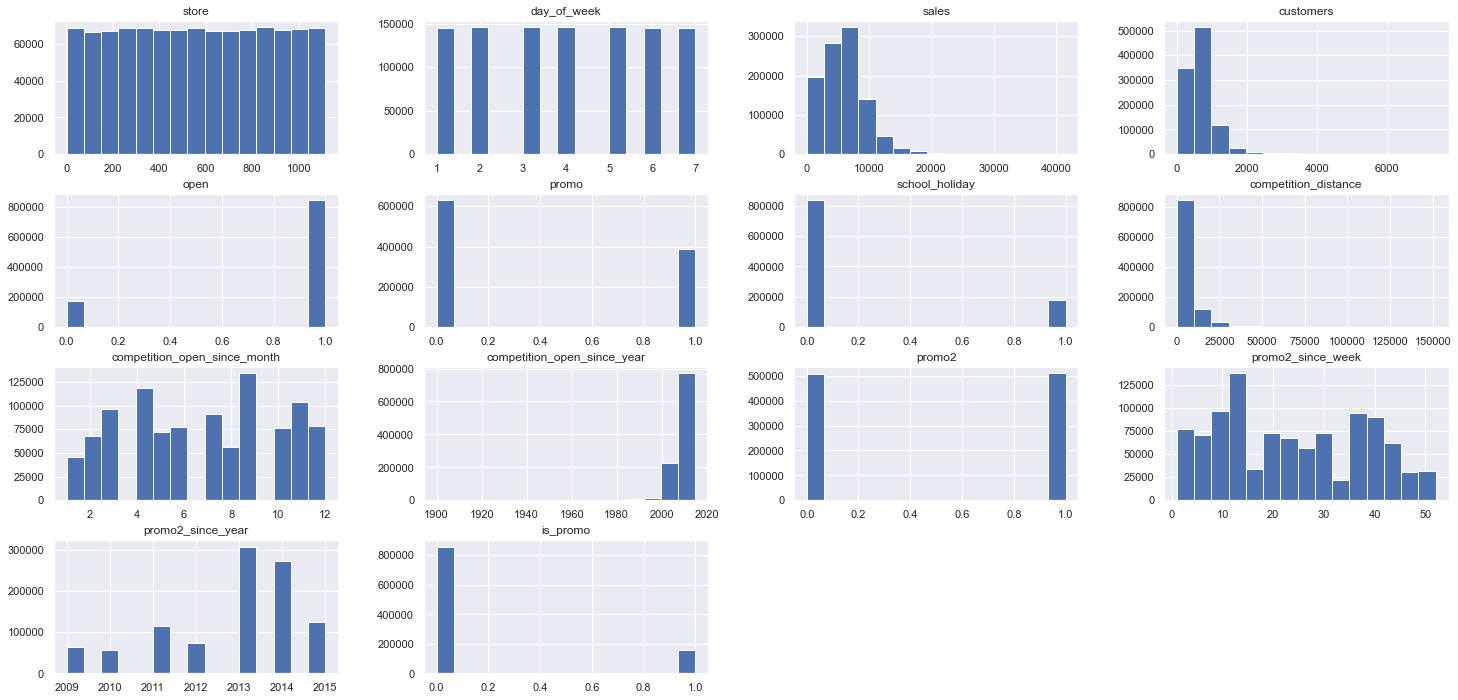

In [32]:
num_attributes.hist(bins =15);

### 4.1.3 Category Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

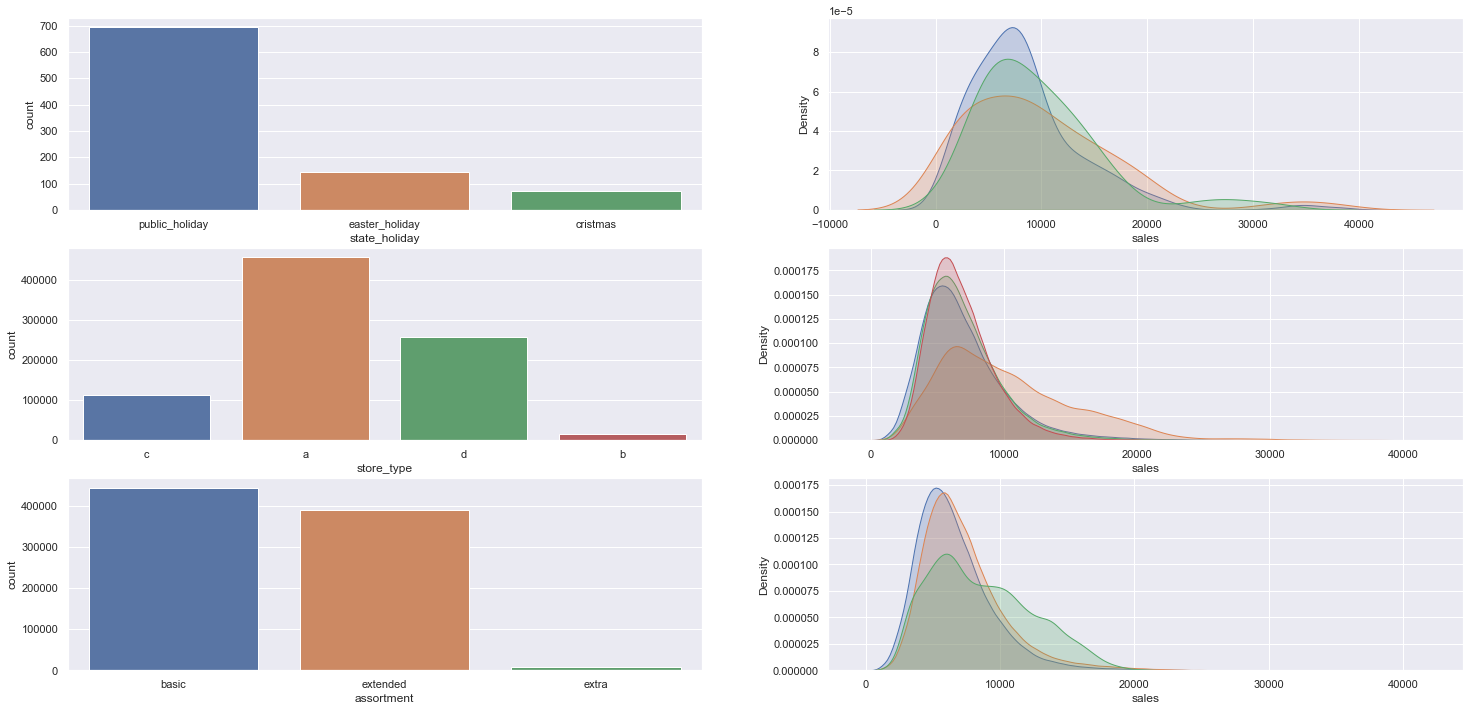

In [33]:
# state_holiday

plt.subplot(3,2,1)

a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label = 'public_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label = 'easter_holiday', shade = True)
sns.kdeplot(df4[df4['state_holiday'] == 'cristmas']['sales'],       label = 'cristmas',       shade = True)

#story_type

plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label = 'a', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label = 'b', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label = 'c', shade = True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label = 'd', shade = True)

#assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label = 'basic', shade= True)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label = 'extended', shade= True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label = 'extra', shade= True)




### H1. Lojas com maior sortimento deveriam vender mais.
**FALSA**  - Lojas com MAIOR SORTIMENTO vendem MENOS. 


<AxesSubplot:xlabel='year_week'>

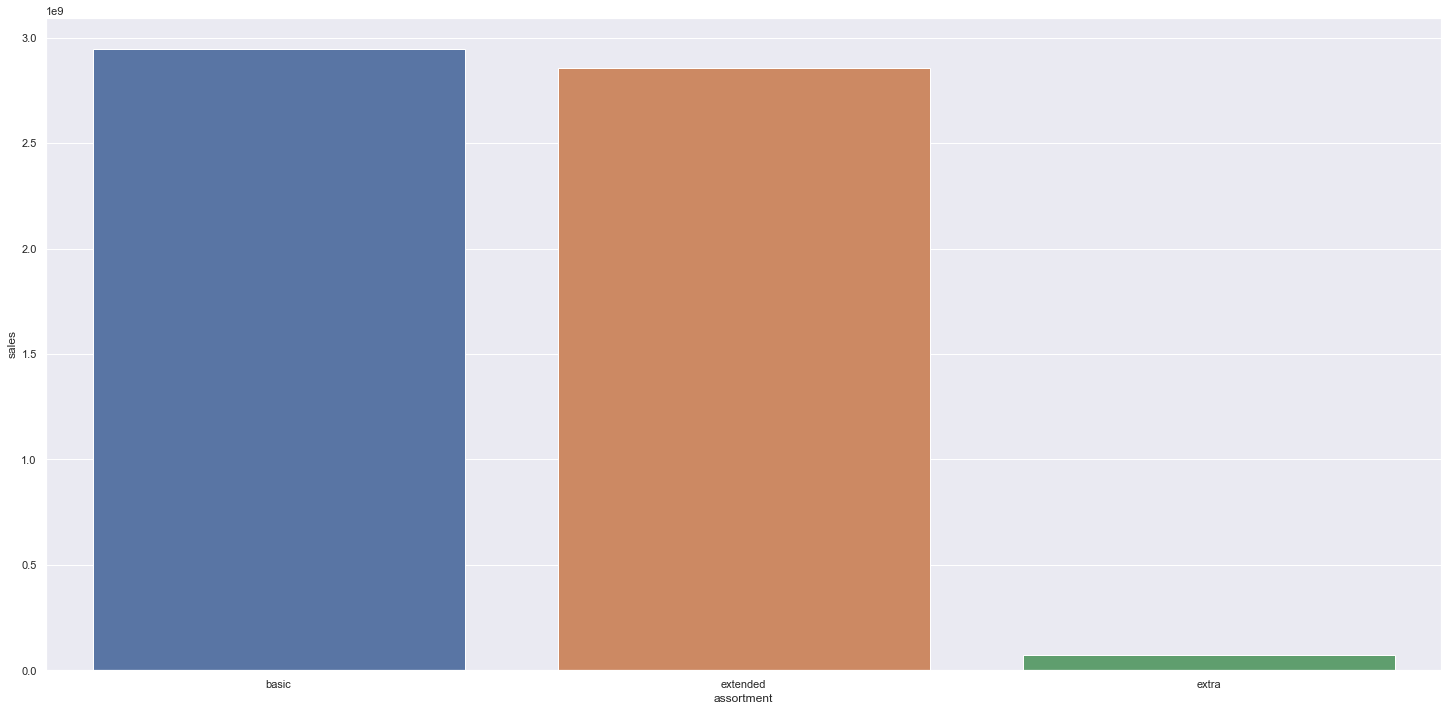

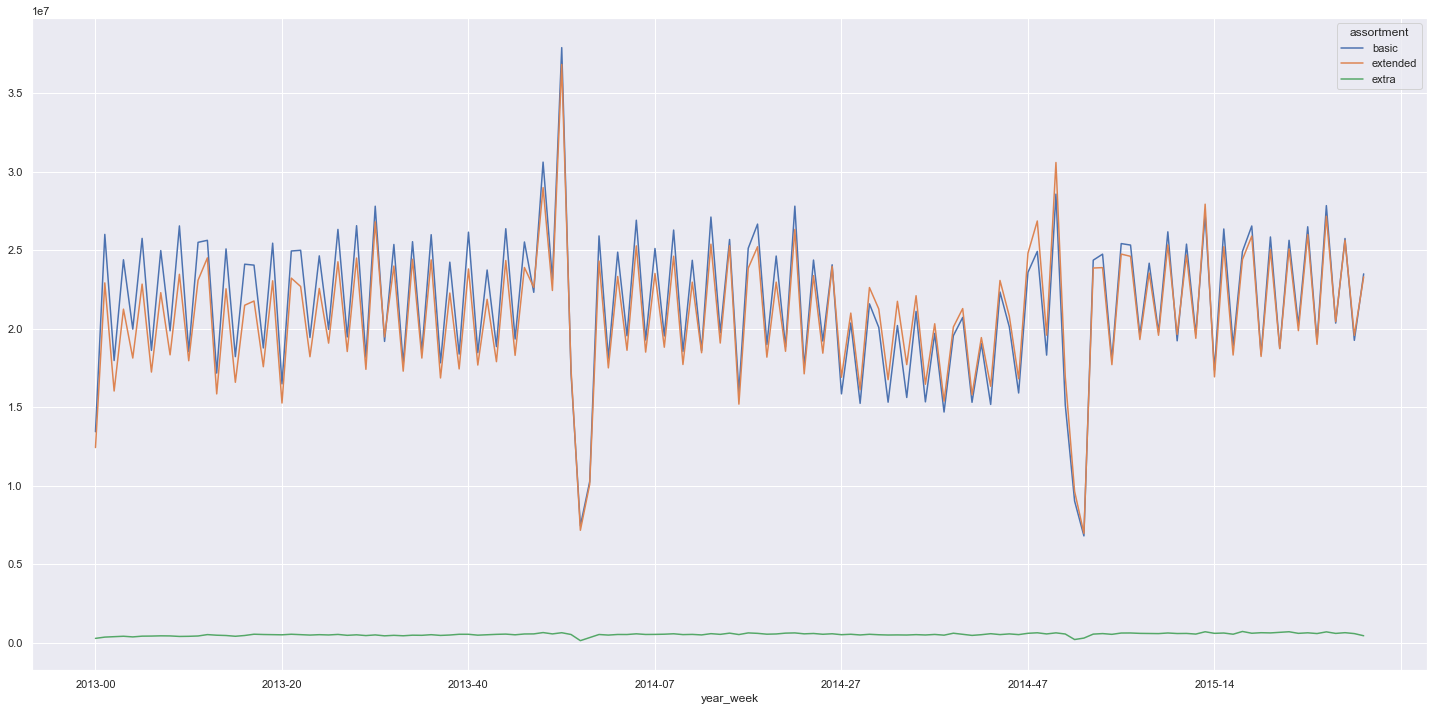

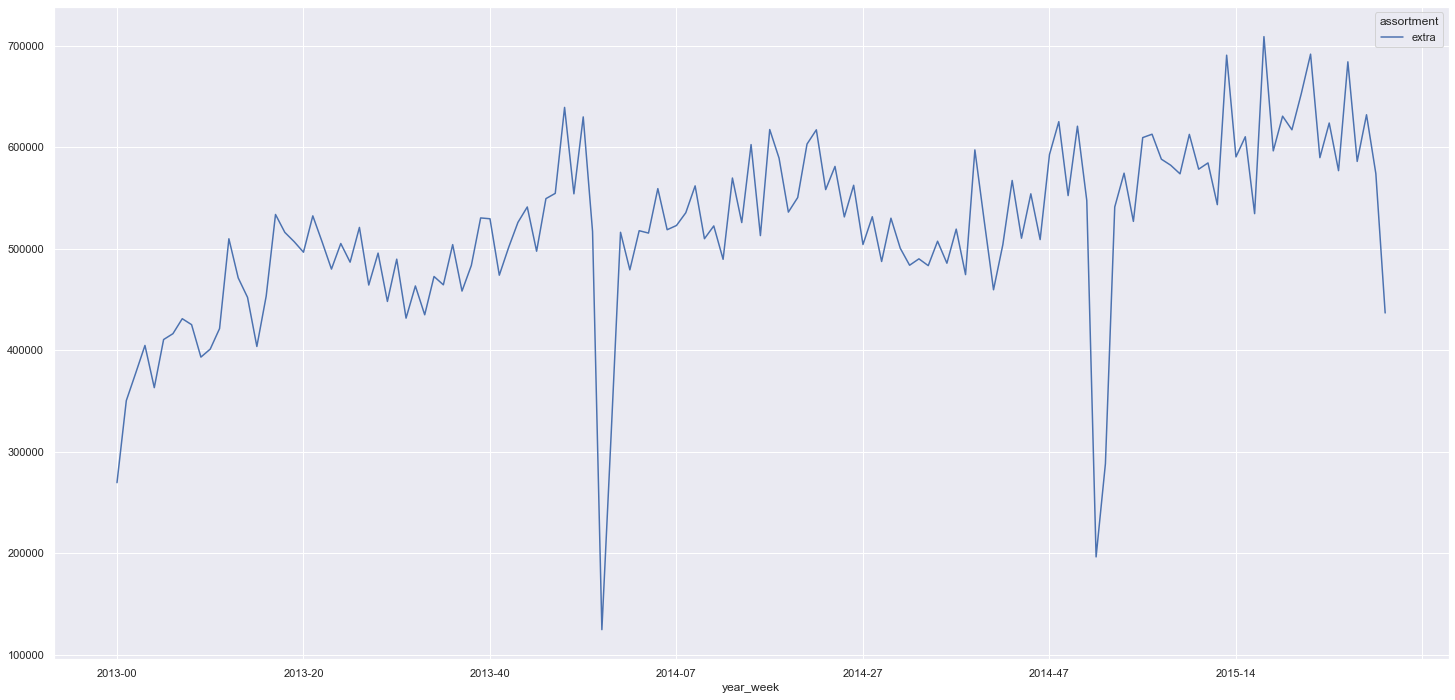

In [34]:
aux1 = df4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(x='assortment',y='sales',data=aux1);

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot()

aux3 = aux2[aux2['assortment']=='extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot()


### H2. Lojas com competidores mais próximos deveriam vender menos.
**FALSA** - Loas com COMPETIDORES mais próximos vendem MAIS.

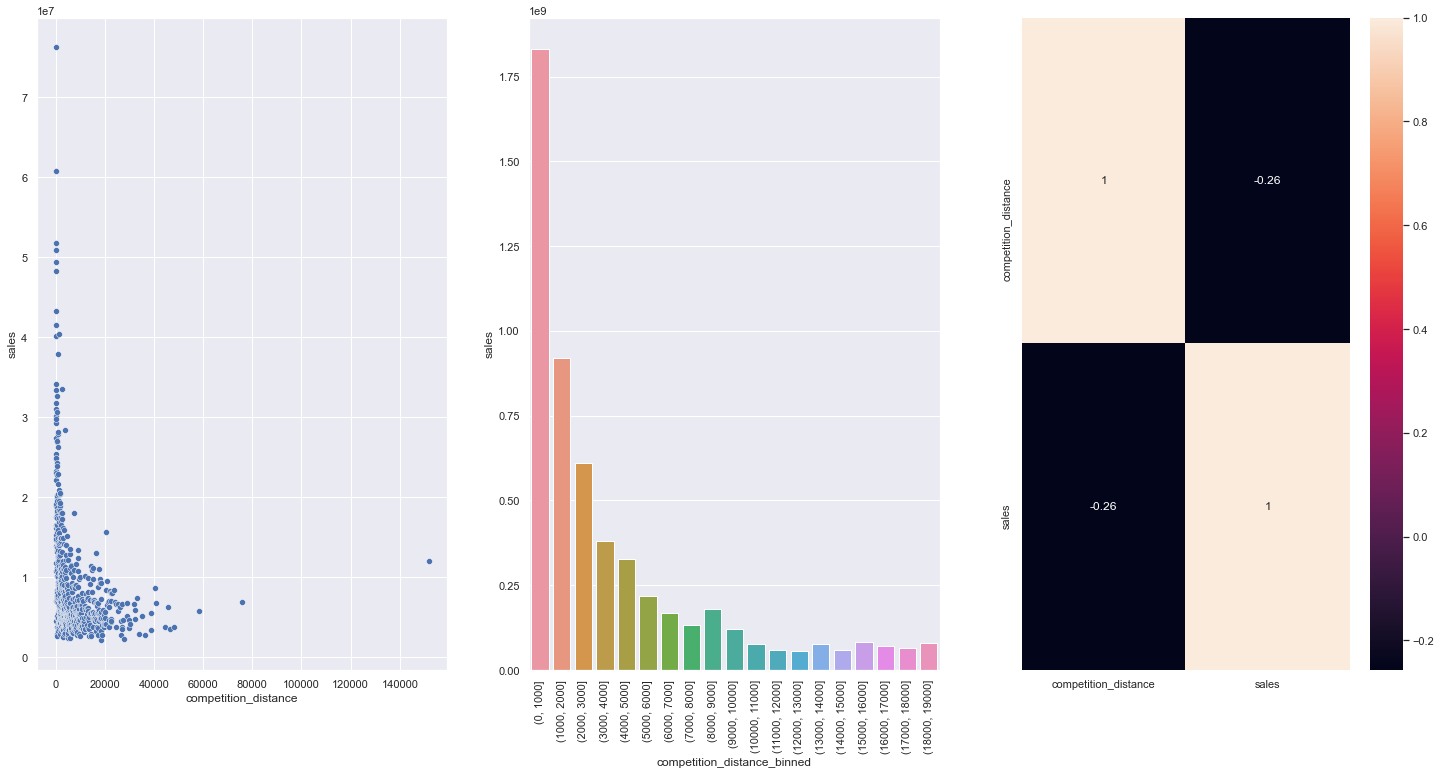

In [35]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.subplot(1,3,1)
sns.scatterplot(x='competition_distance',y='sales', data=aux1)

plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins = bins)
aux2 = aux1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()
#sns.set(rc={'figure.figsize':(15.7,12.27)})
sns.barplot(x='competition_distance_binned', y= 'sales',data= aux2);
plt.xticks(rotation = 90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### H3. Lojas com competidores á mais tempo deveriam vender mais.
**FALSA** - Lojas com COMPETIDORES á mais tempo vendem MENOS.

<AxesSubplot:>

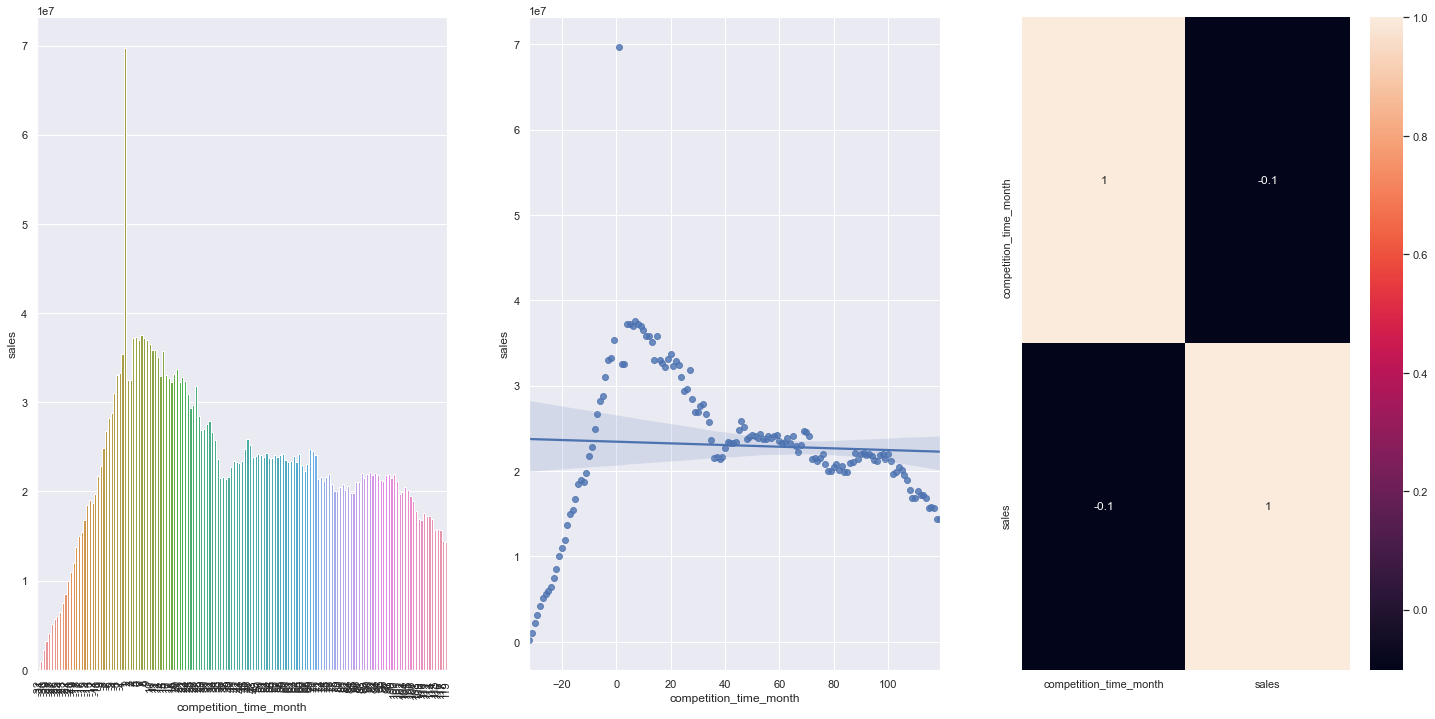

In [36]:
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data= aux2);
plt.xticks(rotation = 90);

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data= aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais.
**FALSA** Lojas com promoções ativas por mais tempo VENDEM MENOS.



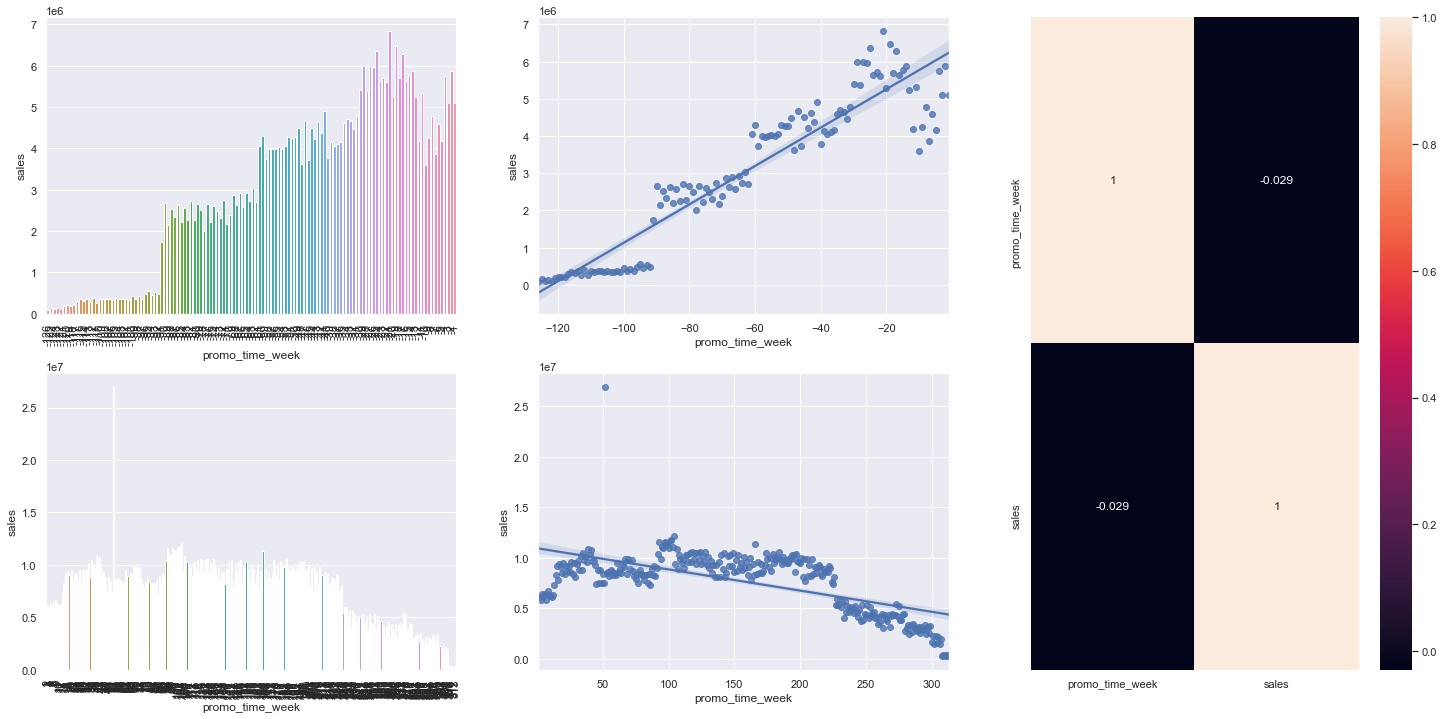

In [37]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
##sns.barplot(x='promo_time_week',y='sales',data =  aux1);

grid = gridspec.GridSpec (2,3)

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] < 0] ## promoção regular
sns.barplot(x='promo_time_week', y='sales', data = aux2);
plt.xticks(rotation =90);

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week', y='sales', data = aux2);

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] > 0] ## promoção extendida
sns.barplot(x='promo_time_week', y='sales',data = aux3);
plt.xticks(rotation = 90);

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week', y='sales', data = aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'), annot=True);

### <s> H5. Lojas com mais dias de promoção deveriam vender mais.</s>



### H6. Lojas com mais promoções consecutivas deveriam vender mais.
**FALSA** Porque lojas com mais promoções consecutivas vendem menos.



In [38]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


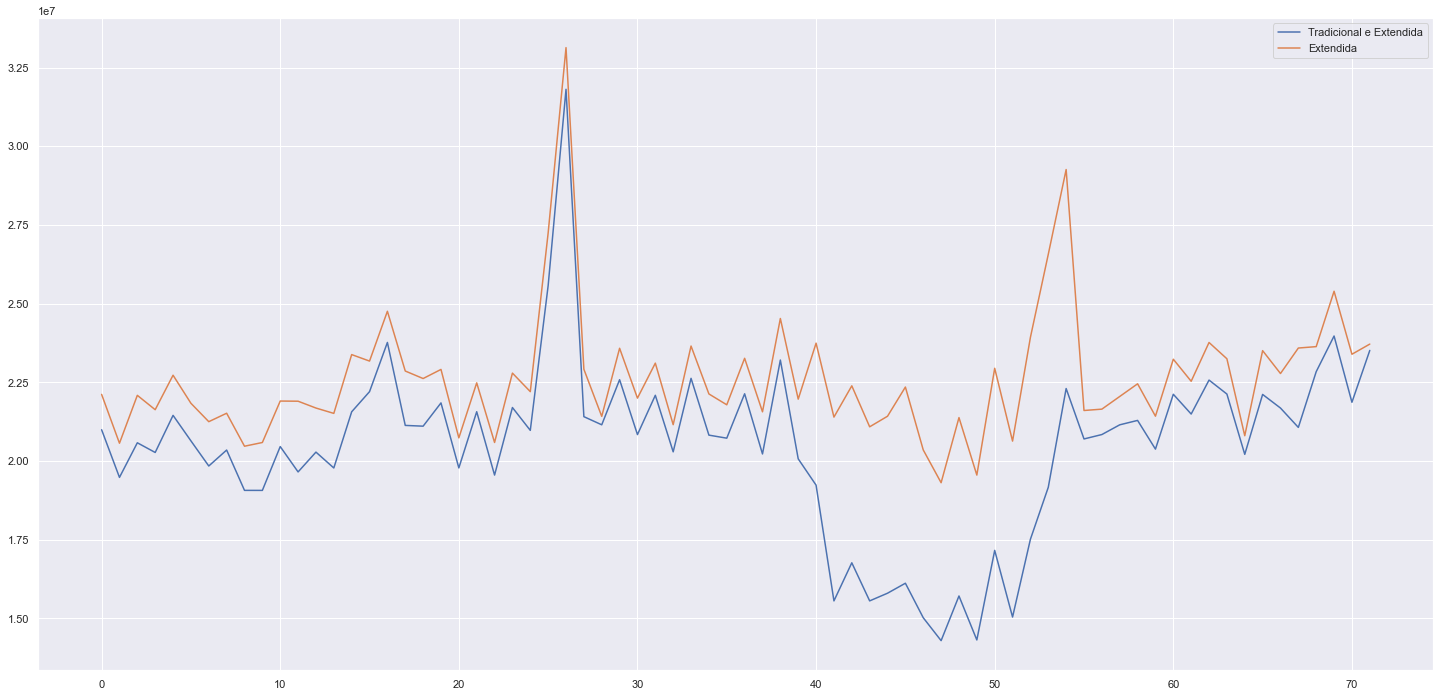

In [39]:
aux1 = df4[(df4['promo'] ==1) & (df4['promo2']==1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot();

aux2 = df4[(df4['promo'] ==1) & (df4['promo2']==0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);

ax.legend(labels=['Tradicional e Extendida','Extendida']);

### H7. Lojas abertas durante o feriado de Natal deveriam vender mais.
**FALSA** Lojas abertas no feriado de Natal vendem Menos.



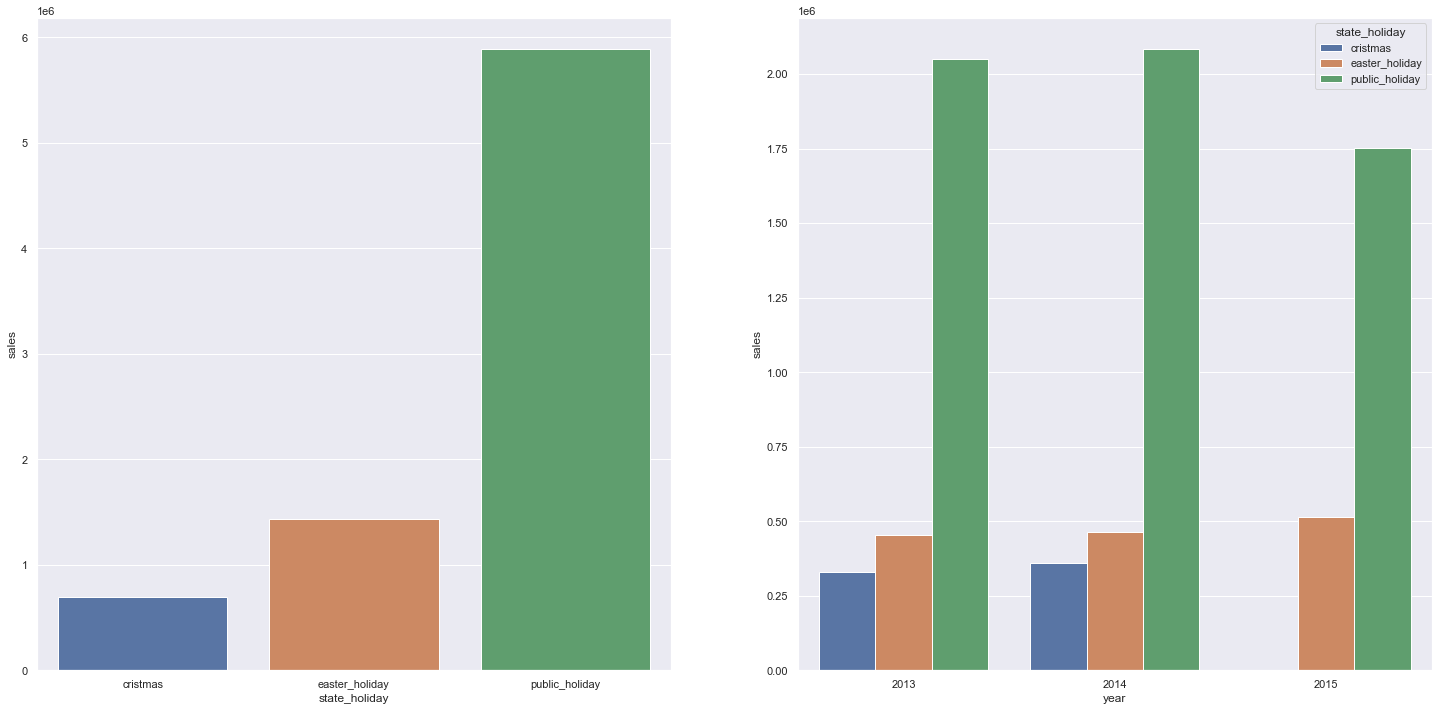

In [40]:
plt.subplot(1,2,1)
aux = df4[df4['state_holiday'] != 'regular_day']
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday',y='sales',data = aux1);

plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales', hue='state_holiday', data=aux2);



### H8. Lojas deveriam vender mais ao longo do ano
**FALSA** Lojas ao longo do ano vendem menos.



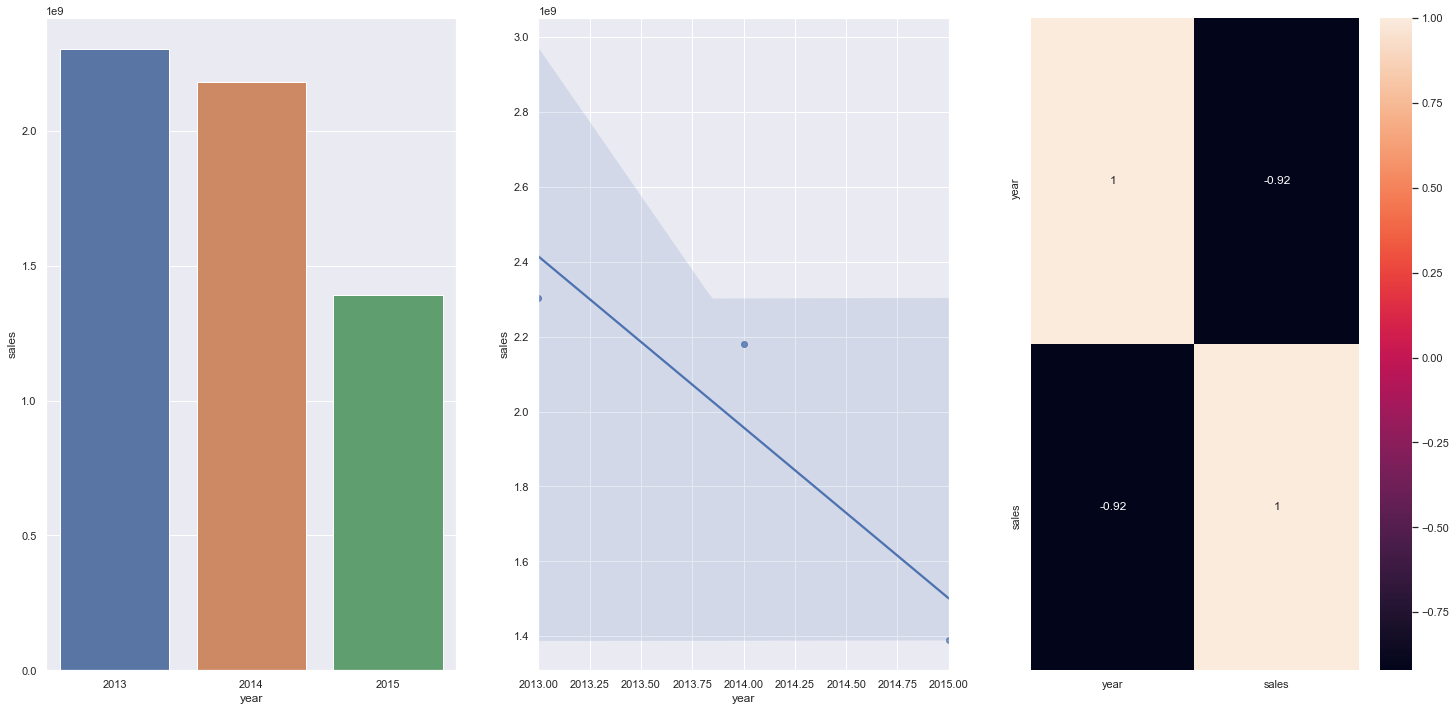

In [41]:
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='year', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot= True);

### H9. Lojas deveriam vender mais no segundo semestre do ano
**VERDADEIRA** Lojas vendem mais no segundo semestre do ano


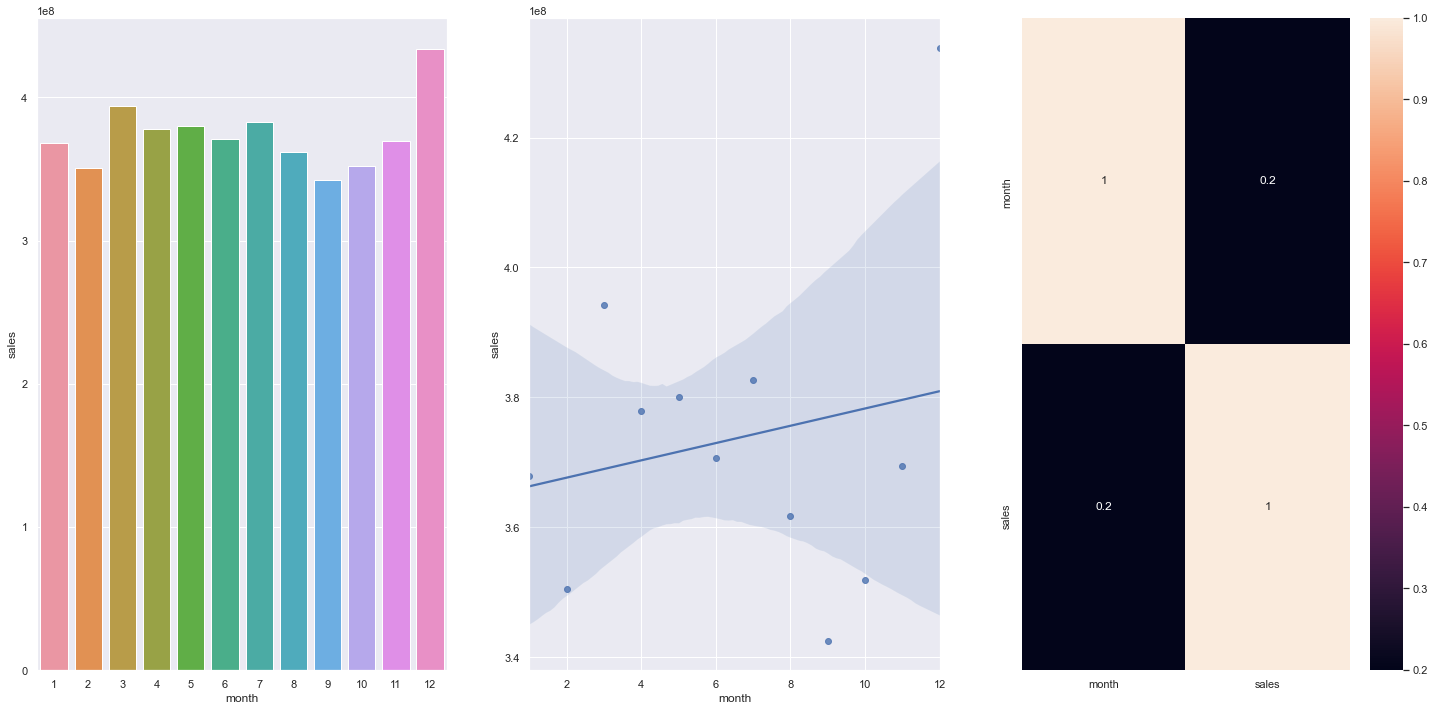

In [42]:
aux = df4[df4['year'] < 2015]
aux1 = aux[['month','sales']].groupby('month').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='month', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot= True);

### H10. Lojas deveriam vender mais depois do dia 10 de cada mês.
**VERDADEIRA** Lojas vendem mais depois do dia 10 de cada mês

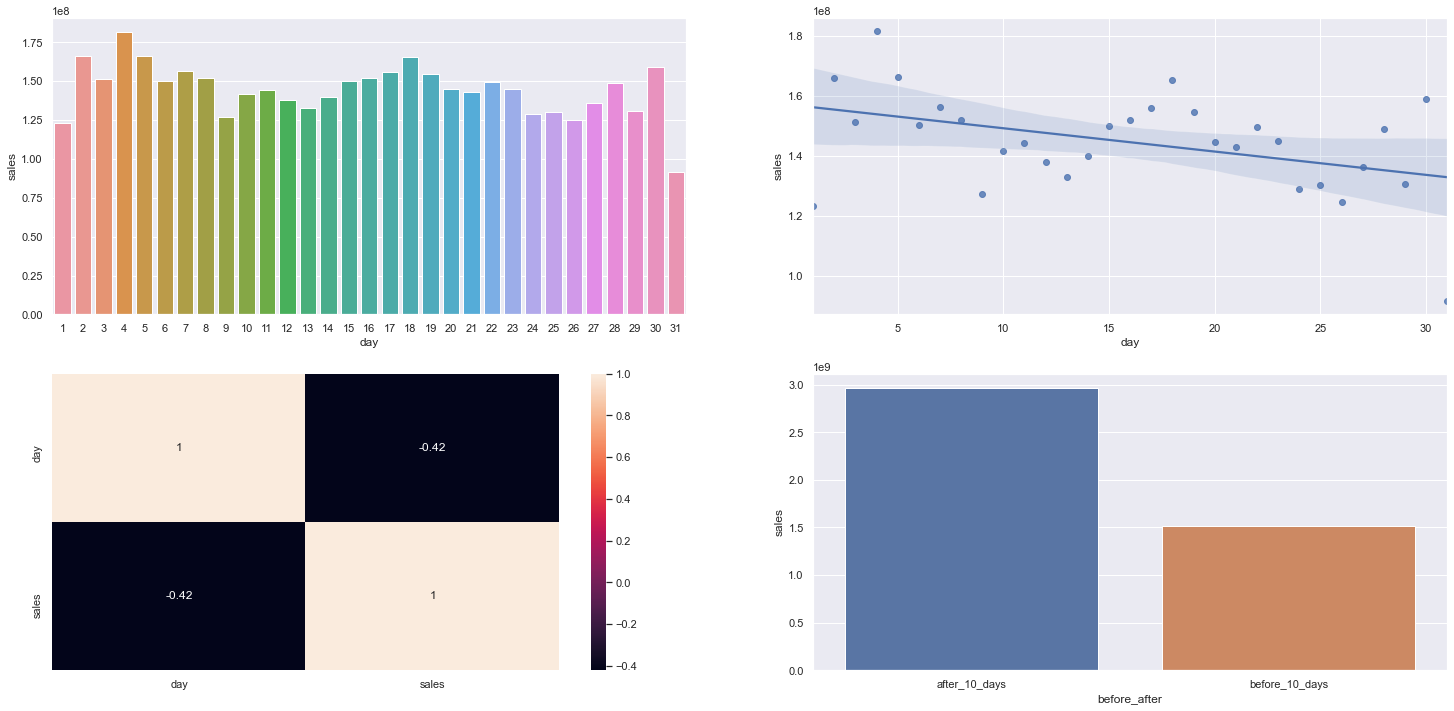

In [43]:
aux = df4[df4['year'] < 2015]
aux1 = aux[['day','sales']].groupby('day').sum().reset_index()

plt.subplot(2,2,1)
sns.barplot(x='day', y='sales', data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data = aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'), annot= True);

plt.subplot(2,2,4)
aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <=10 else 'after_10_days')
aux1 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()
sns.barplot(x='before_after', y='sales', data= aux1);


### H11. Lojas deveriam vender menos ao finais de semana.
**VERDADEIRA** Lojas vendem menos nos finais de semana


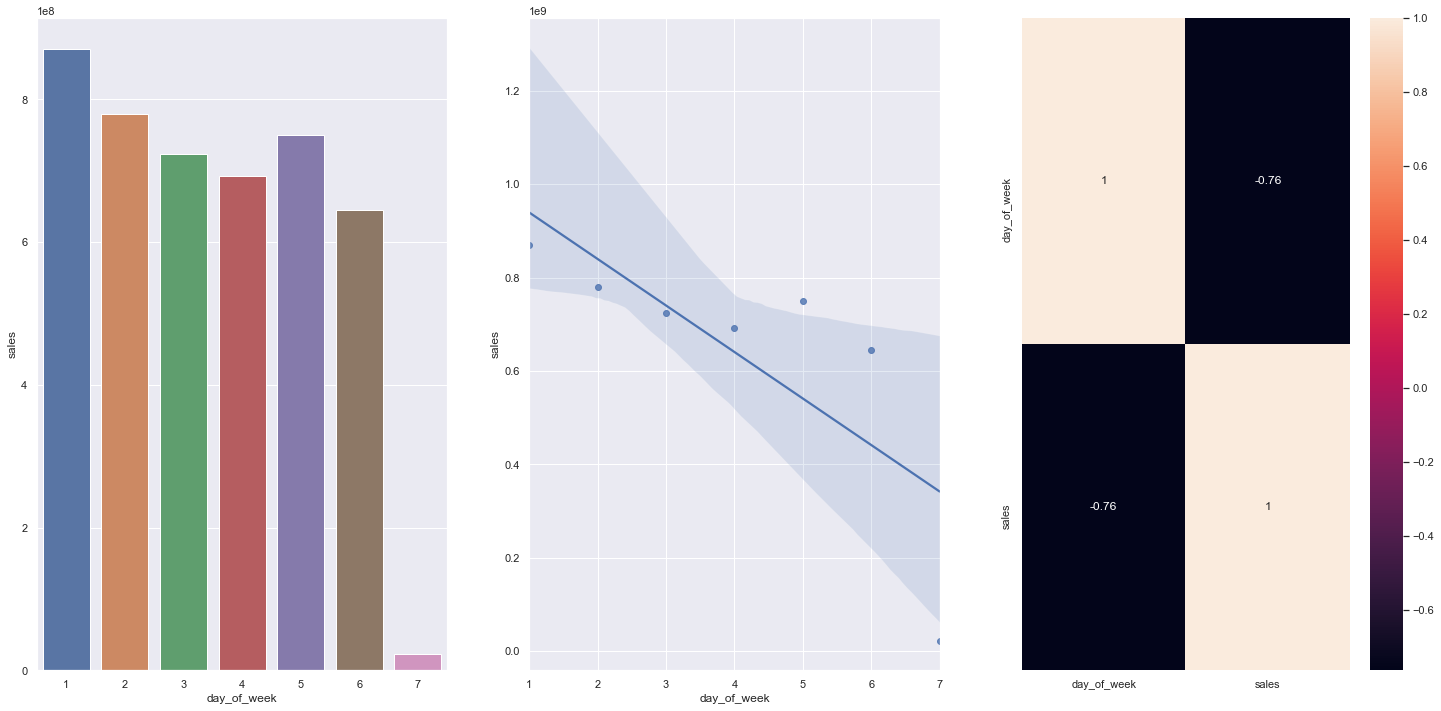

In [44]:
aux = df4[df4['year'] < 2015]
aux1 = aux[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()

plt.subplot(1,3,1)
sns.barplot(x='day_of_week', y='sales', data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data = aux1);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot= True);

### H12. Lojas deveriam vender menos durantes os feriados escolares.
**VERDADEIRA** As lojas vendem menos durantes os feriados escolares, exceto nos meses de julho e agosto.

<AxesSubplot:xlabel='month', ylabel='sales'>

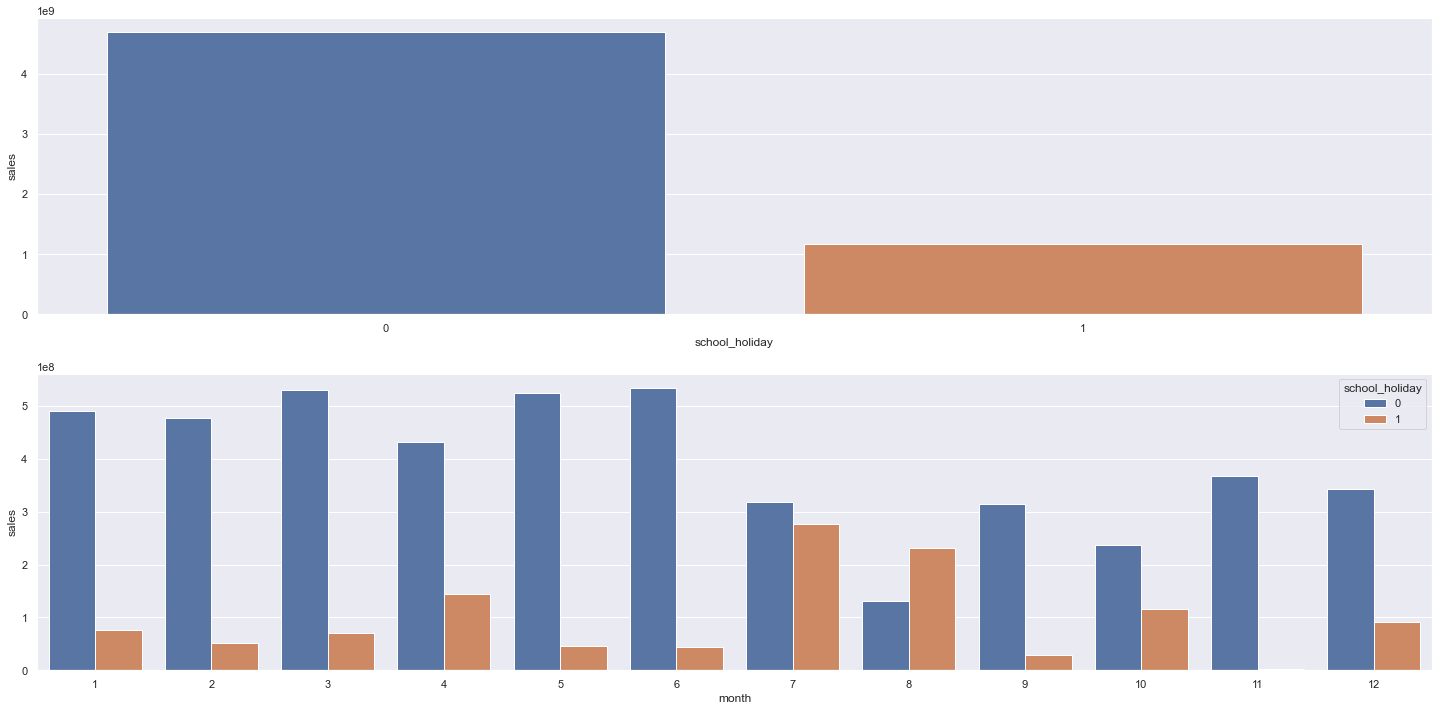

In [45]:
plt.subplot(2,1,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday',y='sales', data= aux1);

plt.subplot(2,1,2)
aux2 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month',y='sales', hue='school_holiday',data=aux2)

## 4.2.3 Resumo das Hipoteses

In [46]:
from tabulate import tabulate

In [47]:
tab = [['Hipotese','Conclusao','Relevancia'],
       ['H1','Falsa','Baixa'],
       ['H2','Falsa','Media'],
       ['H3','Falsa','Media'],
       ['H4','Falsa','Media'],
       ['H5','-','-'],
       ['H6','Falsa','Baixa'],
       ['H7','Falsa','Media'],
       ['H8','Falsa','Alta'],
       ['H9','Verdadeira','Alta'],
       ['H10','Verdadeira','Alta'],
       ['H11','Verdadeira','Alta'],
       ['H12','Verdadeira','Baixa']
      ]
print(tabulate (tab, headers='firstrow'))

Hipotese    Conclusao    Relevancia
----------  -----------  ------------
H1          Falsa        Baixa
H2          Falsa        Media
H3          Falsa        Media
H4          Falsa        Media
H5          -            -
H6          Falsa        Baixa
H7          Falsa        Media
H8          Falsa        Alta
H9          Verdadeira   Alta
H10         Verdadeira   Alta
H11         Verdadeira   Alta
H12         Verdadeira   Baixa


## 4.3 Analise Multivariada

### 4.3.1 Numerical Attributes

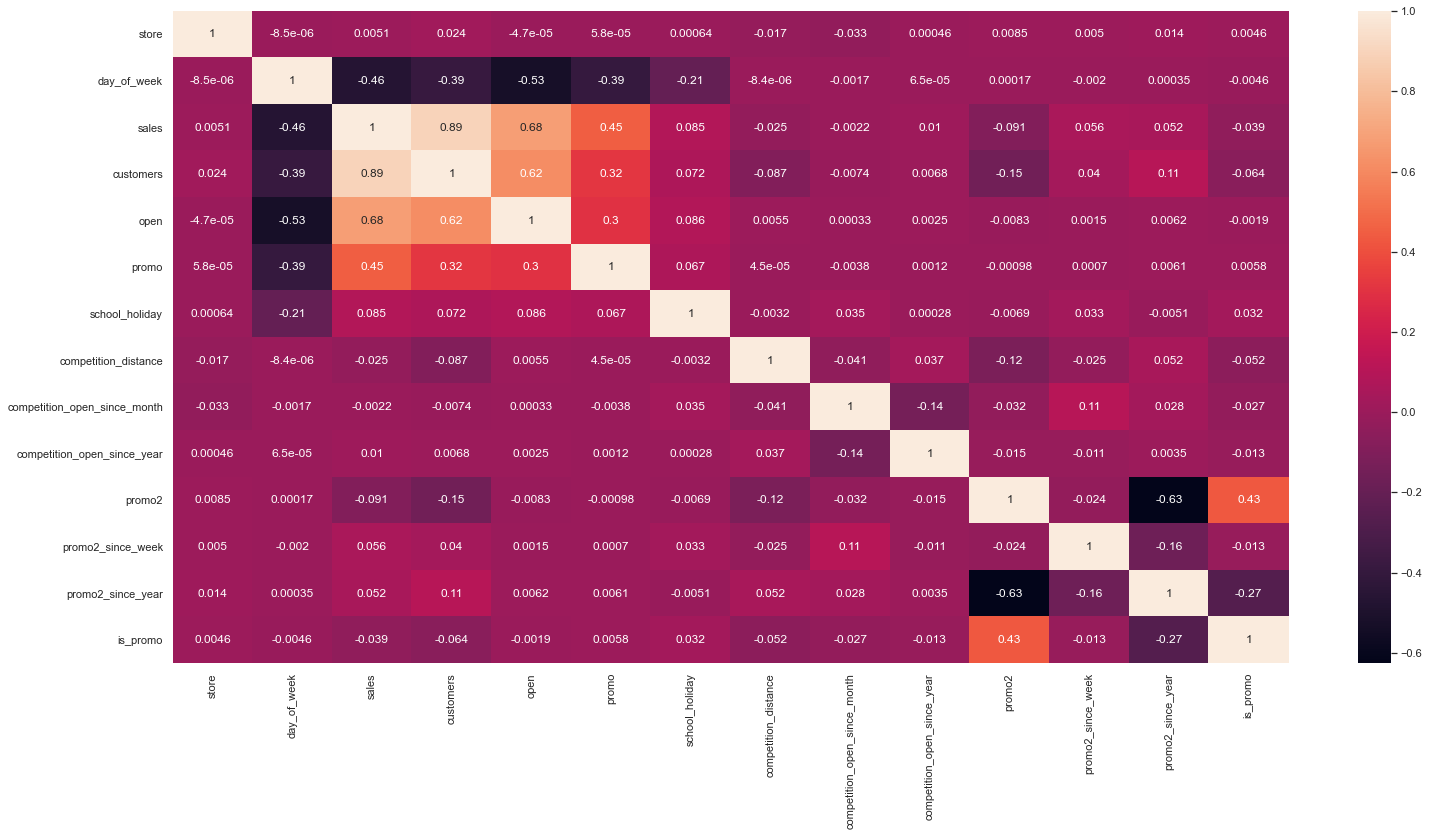

In [48]:
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, annot=True);

### 4.3.2 Categorical Attributes

<AxesSubplot:>

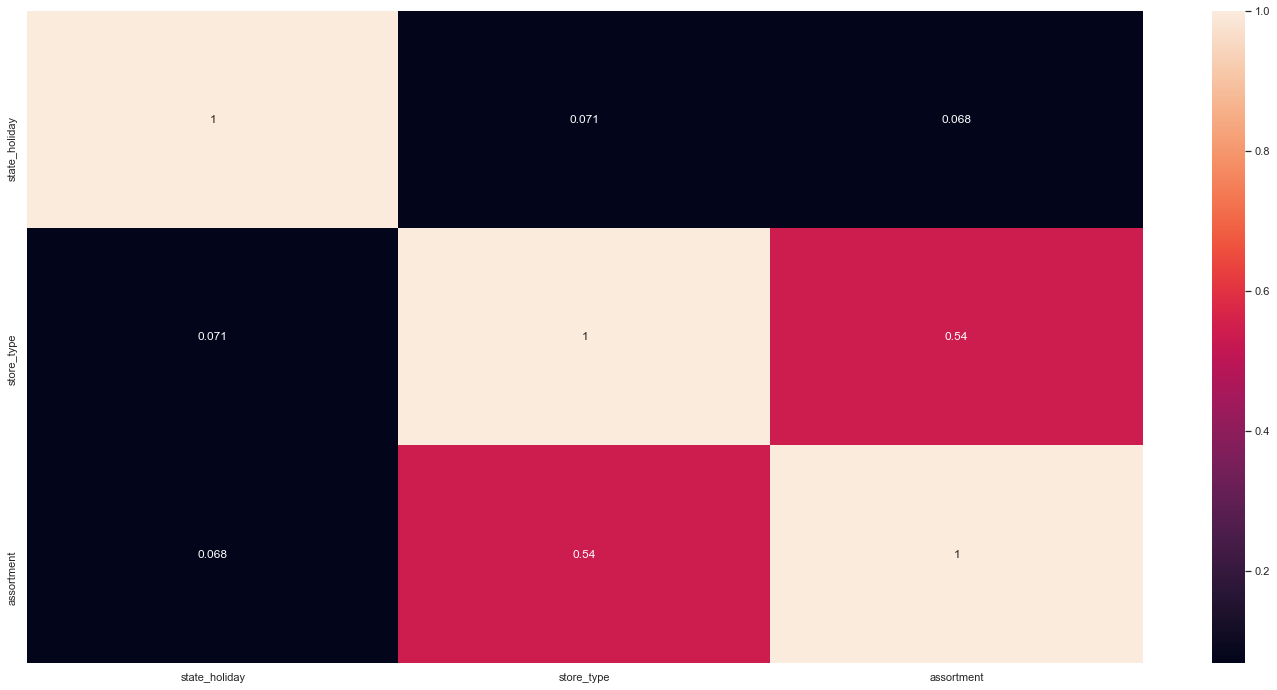

In [49]:
# only categorial data
a = df4.select_dtypes(include='object')

#Calcule crame_v
a1 = cramer_v(a['state_holiday'],a['state_holiday'])
a2 = cramer_v(a['state_holiday'],a['store_type'])
a3 = cramer_v(a['state_holiday'],a['assortment'])

a4 = cramer_v(a['store_type'],a['state_holiday'])
a5 = cramer_v(a['store_type'],a['store_type'])
a6 = cramer_v(a['store_type'],a['assortment'])

a7 = cramer_v(a['assortment'],a['state_holiday'])
a8 = cramer_v(a['assortment'],a['store_type'])
a9 = cramer_v(a['assortment'],a['assortment'])

d = pd.DataFrame({'state_holiday': [a1,a2,a3],
                  'store_type': [a4,a5,a6],
                  'assortment': [a7,a8,a9]})

#Final DataFrame
d = d.set_index(d.columns)

#HeatMap
sns.heatmap(d,annot=True)

# 5.0 PASSO 05 - DATA PREPARATION 

In [50]:
df5 = df4.copy()

## 5.1 Normalização

## 5.2 Rescaling

In [52]:
rs = RobustScaler()
mms = MinMaxScaler()

#competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)

#competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)

#promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)

# year
df5['year'] = mms.fit_transform(df5[['year']].values)

## 5.3 Transformação

### 5.3.1 Enconding

In [53]:
# state holiday - One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type - Label Encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])

# assortment - ordinal Encoding
assortment_dict = {'basic' :1,'extra':2,'extended':3}
df5['assortment'] = df5['assortment'].map(assortment_dict)

### 5.3.2 Response Variable Transformation

In [54]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature Transformation

In [55]:
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin (x * (2. * np.pi/12 ) ) )
df5['month_cos'] = df5['month'].apply(lambda x: np.cos (x * (2. * np.pi/12 ) ) )

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin (x * (2. * np.pi/30 ) ) )
df5['day_cos'] = df5['day'].apply(lambda x: np.cos (x * (2. * np.pi/30 ) ) )

# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin (x * (2. * np.pi/52 ) ) )
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos (x * (2. * np.pi/52 ) ) )

# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin (x * (2. * np.pi/7 ) ) )
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos (x * (2. * np.pi/7 ) ) )


In [56]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competiton_since,competition_time_month,promo_since,promo_time_week,state_holiday_cristmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# 6.0 PASSO 06 - FEATURE SELECTION

In [57]:
df6 = df5.copy()

## 6.1 Split Dataframe into training add test dataset

In [58]:
cols_drop = ['week_of_year','day','month','day_of_week', 'promo_since','competiton_since', 'year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [78]:
# training dataset
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

#test dataset
X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print ('Training Min Date:{}'.format (X_train['date'].min() ) )
print ('Training Min Date:{}'.format (X_train['date'].max() ) )


print ('\nTest Min Date:{}'.format (X_test['date'].min() ) )
print ('Test Min Date:{}'.format (X_test['date'].max() ) )



Training Min Date:2013-01-01 00:00:00
Training Min Date:2015-06-18 00:00:00

Test Min Date:2015-06-19 00:00:00
Test Min Date:2015-07-31 00:00:00


### 6.2 Boruta as Feature Selector


In [60]:
df6.head()

,store,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,competition_time_month,promo_time_week,state_holiday_cristmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,0.918919,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,1.054054,0.922551,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,1.202703,0.801822,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,0.743243,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,-0.162162,0.287016,0,0,0,1,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


In [58]:
##from boruta import BorutaPy
#training and Test dataset Boruta
##x_train_n = x_train.drop(['sales','date'], axis = 1).values
##y_train_n = y_train.values.ravel()

##define RandomForestRegressor
##rf = RandomForestRegressor(n_jobs=-1)

##define boruta
##boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(x_train_n, y_train_n)


### 6.2.1 Best Features from Boruta

In [59]:
##cols_selected = boruta.support_.tolist()

#best features
##x_train_fs = x_train.drop(['date','sales'], axis = 1)
##cols_selected_boruta = x_train_fs.iloc[:,cols_selected].columns.tolist()

#not select boruta
##cols_not_selected_boruta = list(np.setdiff1d(x_train_fs.columns, cols_selected_boruta))


In [60]:
##cols_selected_boruta

## 6.3 Manual Feature Selection

In [61]:
cols_selected_boruta = ['store', 
                        'promo', 
                        'store_type', 
                        'assortment', 
                        'competition_distance',
                        'competition_open_since_month', 
                        'competition_open_since_year', 
                        'promo2',
                        'promo2_since_week', 
                        'promo2_since_year', 
                        'competition_time_month',
                        'promo_time_week', 
                        'month_cos',
                        'month_sin',
                        'day_sin', 
                        'day_cos',
                        'week_of_year_cos',
                        'week_of_year_sin',
                        'day_of_week_sin', 
                        'day_of_week_cos']
#columns to add
feat_to_add = ['date', 'sales']

#final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feat_to_add)



In [62]:
cols_selected_boruta_full

['store',
 'promo',
 'store_type',
 'assortment',
 'competition_distance',
 'competition_open_since_month',
 'competition_open_since_year',
 'promo2',
 'promo2_since_week',
 'promo2_since_year',
 'competition_time_month',
 'promo_time_week',
 'month_cos',
 'month_sin',
 'day_sin',
 'day_cos',
 'week_of_year_cos',
 'week_of_year_sin',
 'day_of_week_sin',
 'day_of_week_cos',
 'date',
 'sales']

# 7.0 PASSO 07 - MACHINE LEARNING MODEL

In [79]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# Time Series Data Preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average Model

In [64]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

#prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns ={'sales':'predictions'})
aux1 = pd.merge(aux1,aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#Perfomance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(yhat_baseline) )
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542


## 7.2 Linear Regression Model 

In [65]:
#model
lr = LinearRegression().fit(x_train, y_train)

#prediction
yhat_lr = lr.predict(x_test)

#performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr) )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1868.367109,0.292879,2670.993696


### 7.2.1 Linear Regression Model - Cross Validation

In [67]:
lr_result_cv = cross_validation(x_training, 5 ,'Linear Regression', lr, verbose=True)
lr_result_cv


Kfold Number:5

Kfold Number:4

Kfold Number:3

Kfold Number:2

Kfold Number:1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.9 +/- 295.72,0.3 +/- 0.02,2951.31 +/- 468.65


## 7.3 Linear Regression Regularized Model

In [68]:
#model
lrr = Lasso(alpha = 0.01).fit(x_train, y_train)

#prediction
yhat_lrr = lrr.predict(x_test)

#performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr) )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1892.318507,0.289171,2744.364675


### 7.3.1 Linear Regression - Lasso - Cross Validation

In [69]:
Lasso_cv = cross_validation(x_training,5,'Lasso', lrr, verbose=False)
Lasso_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.39 +/- 341.57,0.29 +/- 0.01,3057.09 +/- 504.39


## 7.4 Random Forest Regressor Model

In [70]:
#model
rf = RandomForestRegressor(n_estimators=200, n_jobs=-1,random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,677.176379,0.099623,1006.222987


### 7.4.1 Radom Forest Regressor - Cross Validation

In [71]:
rf_cv = cross_validation(x_training,5,'Radom Forest', rf)
rf_cv


Kfold Number:5

Kfold Number:4

Kfold Number:3

Kfold Number:2

Kfold Number:1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,Radom Forest,834.92 +/- 217.35,0.12 +/- 0.02,1251.92 +/- 317.65


## 7.5 Xgboost Regressor Model

In [72]:
#model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                             n_estimatiors =200,
                             eta = 0.01,
                             max_depth=10,
                             subsample =0.7,
                             colsample_bytee = 0.9).fit(x_train, y_train)

#prediction
yhat_xgb = model_xgb.predict(x_test)

#performance
xgb_result = ml_error('XGBoost Regressor ', np.expm1(y_test), np.expm1(yhat_xgb) )
xgb_result

[18:41:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_bytee, n_estimatiors } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,6683.602213,0.949501,7330.746126


### 7.5.1 Xgboost - Cross Validation

In [73]:
xbg_cv = cross_validation(x_training,5,'Xgboost', model_xgb)
xbg_cv


Kfold Number:5
[18:42:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_bytee, n_estimatiors } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Kfold Number:4
[18:43:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_bytee, n_estimatiors } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.



Kfold Number:3
[18:44:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_bytee, n_e

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Xgboost,7047.94 +/- 587.59,0.95 +/- 0.0,7714.01 +/- 688.65


## 7.6 Compare Model´s Performace

## 7.6.1 Single Performace

In [74]:
modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result]  )
modelling_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.455051,1835.135542
0,Linear Regression,1868.367109,0.292879,2670.993696
0,Linear Regression - Lasso,1892.318507,0.289171,2744.364675
0,Random Forest Regressor,677.176379,0.099623,1006.222987
0,XGBoost Regressor,6683.602213,0.949501,7330.746126


### 7.6.2 Real Performance  - Cross Validation

In [75]:
modelling_result_cv = pd.concat([lr_result_cv, Lasso_cv, rf_cv, xbg_cv]  )
modelling_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.9 +/- 295.72,0.3 +/- 0.02,2951.31 +/- 468.65
0,Lasso,2116.39 +/- 341.57,0.29 +/- 0.01,3057.09 +/- 504.39
0,Radom Forest,834.92 +/- 217.35,0.12 +/- 0.02,1251.92 +/- 317.65
0,Xgboost,7047.94 +/- 587.59,0.95 +/- 0.0,7714.01 +/- 688.65


# 8.0 PASSO 08 - HYPERPARAMETER FINE TUNNING

## 8.1 Random Search


In [76]:
param = {'n_estimators': [1500 ,1700 ,2500 ,2300 ,3500],
         'eta': [0.01 , 0.03],
         'max_depth': [3, 5, 9],
         'subsample': [0.1, 0.5, 0.7],
         'colsample_bytree':[0.3, 0.7, 0.9],
         'min_child_weight':[3 ,8 ,15]
        }
MAX_EVAL = 5

In [77]:
#final_result = pd.DataFrame()

for i in range(MAX_EVAL):
    #Chosse values for parameter ramndomly
    hp = {k: random.sample(v,1)[0] for k,v in param.items() }
    print(hp)
    #model
    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimatiors =hp['n_estimators'],
                                 eta = hp['eta'],
                                 max_depth=hp['max_depth'],
                                 subsample =hp['subsample'],
                                 colsample_bytee = hp['colsample_bytree'],
                                 min_child_weight = hp['min_child_weight'])

    
    #performance
    result = cross_validation(x_training, 5 ,'XGBoost Regressor ', model_xgb, verbose = False )
    final_result = pd.concat([final_result, result])

#final_result

TypeError: random_sample() takes at most 1 positional argument (2 given)

## 8.2 Final Model

In [66]:
param_tuned = {'n_estimators':3500 ,
         'eta': 0.03,
         'max_depth':5,
         'subsample':0.7,
         'colsample_bytree':0.7,
         'min_child_weight':3
        }

In [67]:
#model final
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror',
                                 n_estimatiors =param_tuned['n_estimators'],
                                 eta = param_tuned['eta'],
                                 max_depth=param_tuned['max_depth'],
                                 subsample =param_tuned['subsample'],
                                 colsample_bytee = param_tuned['colsample_bytree'],
                                 min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

#predciton
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

#performance
xgb_result_tuned = ml_error('XGboost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

[04:59:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:541: 
Parameters: { colsample_bytee, n_estimatiors } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,Model Name,MAE,MAPE,RMSE
0,XGboost Regressor,2749.778379,0.341482,3693.14091


In [68]:
#model
rf = RandomForestRegressor(n_estimators=300, n_jobs=-1,random_state=42).fit(x_train, y_train)

#prediction
yhat_rf = rf.predict(x_test)

#performance
rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(yhat_rf) )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,676.701482,0.099568,1006.11284


# 9.0 PASSO 09 - TRADUCAO E INTERPRETACAO DO ERRO

In [85]:
df9 = X_test[cols_selected_boruta_full]

#Rescale
df9['sales'] = np.expm1(df9['sales'])
df9['predictions'] = np.expm1( yhat_rf )

## 9.1 Business Performance

In [102]:
#Sum prediction
df91 = df9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'],x['predictions'])).reset_index().rename(columns = {0:'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'],x['predictions'])).reset_index().rename(columns = {0:'MAPE'})

#Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92= pd.merge(df91, df9_aux3, how='inner', on='store')

#Scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

#Order columns
df92 = df92[['store','predictions', 'worst_scenario','best_scenario','MAE','MAPE']]

In [105]:
df92.sort_values('MAE', ascending = False).head()

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
908,909,250042.446402,243007.705584,257077.187219,7034.740817,0.490687
875,876,213054.374623,209164.908285,216943.840961,3889.466338,0.301836
291,292,109110.446645,105530.167074,112690.726217,3580.279572,0.612938
841,842,739891.036459,737425.983953,742356.088965,2465.052506,0.122526
1113,1114,787551.838946,785543.668909,789560.008983,2008.170037,0.084905


In [103]:
df92.sample(5)

,store,predictions,worst_scenario,best_scenario,MAE,MAPE
149,150,300957.915931,299964.374403,301951.457459,993.541528,0.113935
471,472,190298.578963,189832.586052,190764.571875,465.992912,0.084783
861,862,295959.245989,295259.258242,296659.233735,699.987746,0.079402
34,35,431301.495684,429839.924797,432763.066571,1461.570887,0.133050
674,675,145412.332718,144848.493713,145976.171723,563.839005,0.161931


<AxesSubplot:xlabel='store', ylabel='MAPE'>

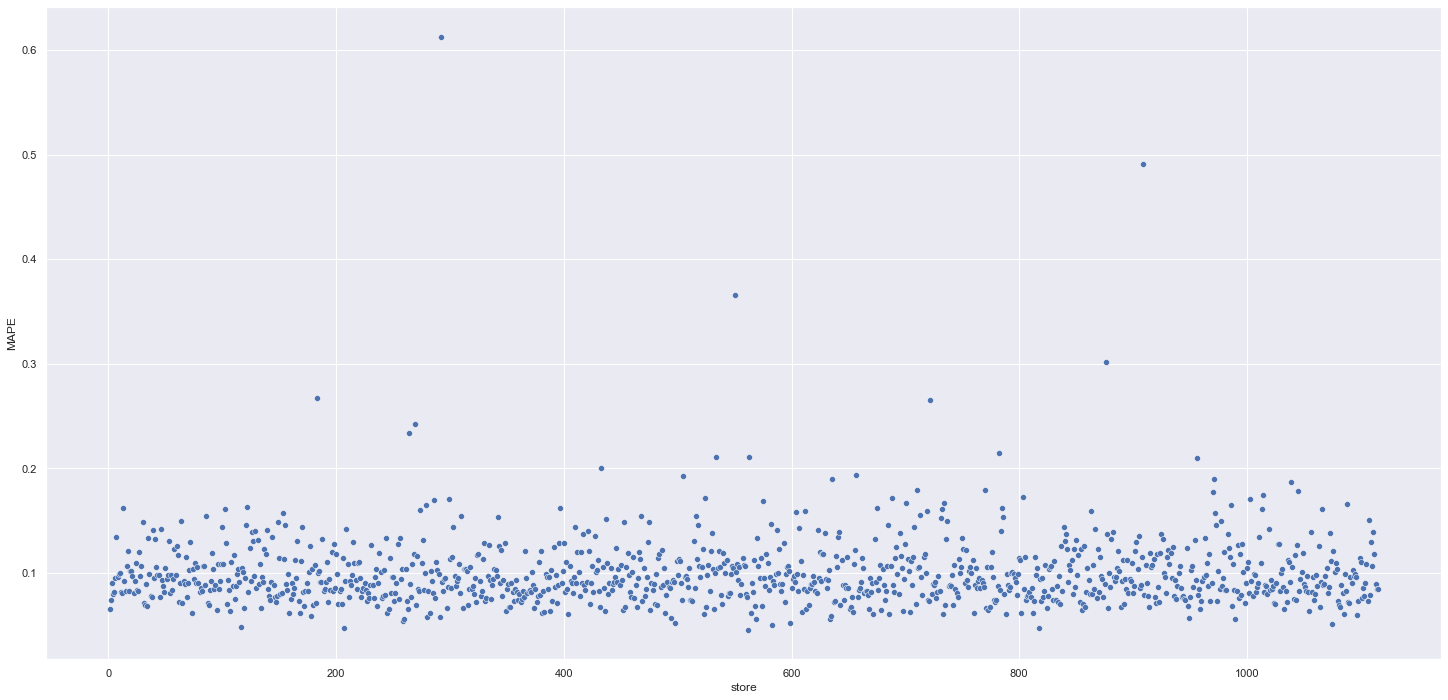

In [106]:
sns.scatterplot(x='store', y='MAPE', data=df92)

## 9.2 Total Performance

In [111]:
df93 =df92[['predictions','worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index':'scenarios',0:'values'})
df93['values'] = df93['values'].map('R${:,.2f}'.format)
df93

,scenarios,values
0,predictions,"R$289,342,421.94"
1,worst_scenario,"R$288,584,273.11"
2,best_scenario,"R$290,100,570.76"


## 9.3 Machine Learning Performance

In [112]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

<AxesSubplot:xlabel='predictions', ylabel='error'>

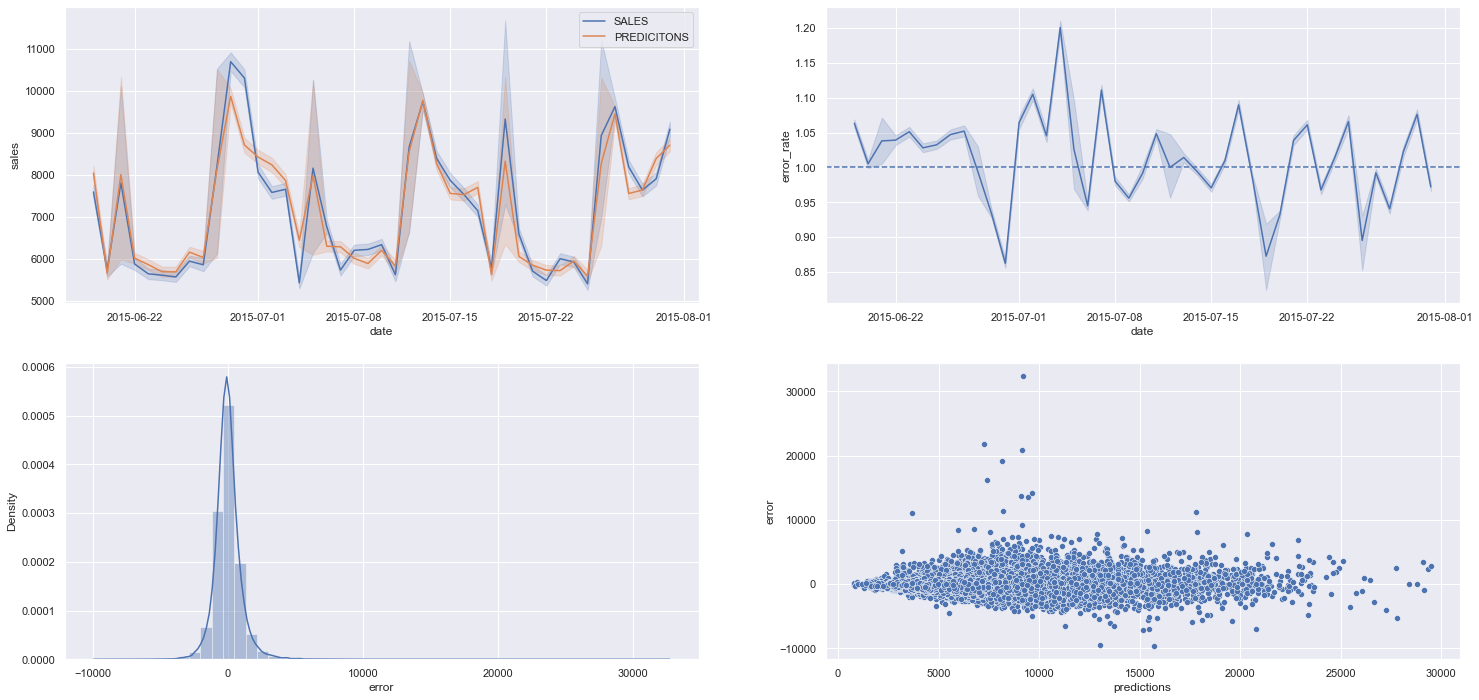

In [117]:
plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='SALES')
sns.lineplot(x='date', y='predictions', data=df9, label='PREDICITONS')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data= df9)
plt.axhline(1, linestyle = '--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])


In [70]:
pickle.dump(xgb_result_tuned, open ('/Users/paulo.andrade/repos/Ds-Em-Producao/model_xgb_rossman.pkl', 'wb'))

In [69]:
pickle.dump(rf_result, open ('/Users/paulo.andrade/repos/Ds-Em-Producao/model_rf_rossman.pkl', 'wb'))